In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.compat.v1.enable_eager_execution()

In [4]:
inputs_train = np.load("inputs_train_180.npy")
inputs_test = np.load("inputs_test_180.npy")

In [91]:
import numpy as np
def normalize(data, window, step):
    frame = '_1min'
    values = [c for c in data.columns if frame in c]
    ohlc = data.iloc[step - window + 1:step + 1][values].copy()

    min_low = ohlc[values].min().min()
    for c in ohlc.columns:
        ohlc[c] -= min_low

    max_high = ohlc[values].max().max()
    for c in ohlc.columns:
        ohlc[c] /= max_high

    return ohlc.values

In [7]:
window_size = 180

In [92]:
%%time
inputs_train = []
for i in range(window_size-1, len(train)):
    if i % 1000 == 0:
        print(i)
    inputs_train.append(normalize(train, window_size , i))
inputs_train = np.array(inputs_train)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
Wall time: 4min 43s


In [93]:
%%time
inputs_test = []
for i in range(window_size-1, len(test)):
    if i % 1000 == 0:
        print(i)
    inputs_test.append(normalize(test, window_size , i))
inputs_test = np.array(inputs_test)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
Wall time: 1min 34s


In [238]:
np.save("inputs_train_180", inputs_train)
np.save("inputs_test_180", inputs_test)

In [8]:
train = pd.read_csv('train_timeframes.csv').iloc[window_size-1:]
test = pd.read_csv('test_timeframes.csv').iloc[window_size-1:]

In [9]:
df = [train, test]

In [10]:
img = inputs_train[0,:,:]

In [11]:
inputs_train.shape, train.shape

((73516, 180, 4), (73575, 23))

In [12]:
inputs_test.shape, test.shape

((24186, 180, 4), (24245, 23))

In [13]:
idx = 0
margin_size = 50
time_limit = 1

In [14]:
def get_model():
    model = models.Sequential()
    # model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
    model.add(LSTM(32, input_shape = img.shape, dropout=0.5))
    # model.add(LSTM(32, dropout=0.2))
    model.add(Dense(1, activation = "tanh"))
    return model

model = get_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [17]:
buffer_train = train.shape[0] - inputs_train.shape[0] -time_limit - 1
buffer_test = test.shape[0] - inputs_test.shape[0] -time_limit - 1

In [18]:
all_closes_train = tf.convert_to_tensor([df[0].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[0])-buffer_train)])
all_closes_test = tf.convert_to_tensor([df[1].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[1])-buffer_test)])

In [19]:
all_spread_train = tf.convert_to_tensor([df[0].iloc[i:i+1]['spread'].tolist() for i in range(len(df[0])-buffer_train)])
all_spread_test = tf.convert_to_tensor([df[1].iloc[i:i+1]['spread'].tolist() for i in range(len(df[1])-buffer_test)])

In [147]:
np.save(open('all_closes_train', 'wb'), all_closes_train.numpy())
np.save(open('all_closes_test', 'wb'), all_closes_test.numpy())
np.save(open('all_spread_train', 'wb'), all_spread_train.numpy())
np.save(open('all_spread_test', 'wb'), all_spread_test.numpy())

In [30]:
all_closes_train = tf.convert_to_tensor(np.load('all_closes_train.npy'))[:,:,:time_limit+1]
all_closes_test = tf.convert_to_tensor(np.load('all_closes_test.npy'))[:,:,:time_limit+1]
all_spread_train = tf.convert_to_tensor(np.load('all_spread_train.npy'))[:,:,:time_limit+1]
all_spread_test = tf.convert_to_tensor(np.load('all_spread_test.npy'))[:,:,:time_limit+1]

In [20]:
all_closes_train.shape, all_spread_train.shape

(TensorShape([73518, 2]), TensorShape([73518, 1]))

In [34]:
def custom_loss_wrapper(idx, margin_size):  
    def custom_loss(y_true, y_pred):
#         print()
#         print(y_pred[:,:1][0].numpy())
        margin = y_pred[:,:1]
#         margin *= margin_size
        direction = tf.sign(margin)
        
        idxs = y_true[:,1]
        df_name = y_true[0][0]
        closes = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_closes_train, idxs), lambda: tf.gather(all_closes_test, idxs))
#         spread = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_spread_train, idxs), lambda: tf.gather(all_spread_test, idxs))
        close1 = closes[:,:1]
        close2 = closes[:,-1:]

        diff = close2 - close1
        profit = -100 * margin_size * (margin * diff) /  close1
#         print(close1[0].numpy(), close2[0].numpy(), margin[0].numpy(), diff[0].numpy(), profit[0].numpy())
#         print(profit.numpy())
#         print(tf.pow(profit, 1.0/3.0).numpy())
#         print(profit.shape, spread.shape, close1.shape, close2.shape)
#         return tf.where(tf.less(tf.abs(profit), 0.5), tf.zeros_like(profit), profit)
#         return tf.where(tf.less(profit, 0), -tf.pow(tf.abs(profit), 1.0/2.0), tf.pow(tf.abs(profit), 1.0/2.0))
#         return tf.where(tf.less(profit, 0), -tf.sqrt(tf.abs(profit)), tf.sqrt(tf.abs(profit)))
#         return tf.where(tf.less(tf.abs(profit), 1), tf.sign(profit)*tf.sqrt(tf.abs(profit)), profit)
#         return tf.pow(profit, 3.0)
        return profit
    return custom_loss

In [74]:
def get_profit(data, y_preds, margin_lower_limit=0):
    preds = y_preds.flatten()[:-time_limit]
    margin = preds*margin_size
    direction = np.sign(preds)
    b = data.shape[0] - preds.shape[0]
    close1 = data['close_1min'].values[:-b]
    close2 = data['close_1min'].values[time_limit:-b+time_limit]
    diff = close2 - close1
    spread = data['spread'].values[:-b]
    profit = 100 * (margin * (diff - (spread*direction))) /  close1
    profit = [p if m > margin_lower_limit else 0 for p, m in zip(profit, margin)]
    return profit

In [ ]:
def get_profit(data, y_preds, margin_lower_limit=0):

In [28]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(inputs_train[:-buffer_train], verbose=0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))
            print()
            y_pred = self.model.predict(inputs_test[:-buffer_test], verbose=0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))            
            profits = get_profit(df[1], y_pred)
            print(sum(profits))
#             print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
# buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(
    validation_data=(inputs_train[:-buffer_train], np.array([[1, i] for i in range(len(inputs_train)-buffer_train)]))
    , interval=10
)

In [35]:
model = get_model()

In [36]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), #, epsilon=1.0),
    loss=custom_loss_wrapper(idx, margin_size),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=False
)

In [144]:
history = model.fit(
    tf.convert_to_tensor(inputs_train[:-buffer_train]), 
    tf.convert_to_tensor([[0, i] for i in range(len(inputs_train)-buffer_train)]), 
    validation_data=(tf.convert_to_tensor(inputs_test[:-buffer_test]), tf.convert_to_tensor([[1, i] for i in range(len(inputs_test)-buffer_test)])),
    epochs=10000, shuffle=True,
    batch_size=32,
    callbacks=[ival],
    use_multiprocessing=True, verbose=1, 
    validation_freq=10,
    workers=64,
#     initial_epoch=model.history.epoch[-1],
)

Epoch 1/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1058
[-0.99910843]
[-0.31051123]
[0.99999994]

[-0.99905056]
[-0.2944689]
[0.99999994]
-3312.2523672203
Epoch 2/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1076
Epoch 3/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1022
Epoch 4/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1083
Epoch 5/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1067
Epoch 6/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1059
Epoch 7/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1081
Epoch 8/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1086
Epoch 9/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1001
Epoch 10/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.0996 - val_loss: -0.0747


2296/2296 [==============================] - 17s 7ms/step - loss: -0.1131
Epoch 83/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1169
Epoch 84/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1086
Epoch 85/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1077
Epoch 86/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1097
Epoch 87/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1136
Epoch 88/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1121
Epoch 89/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1143
Epoch 90/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.1175 - val_loss: -0.0885
Epoch 91/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1175
[-0.99999887]
[0.05101241]
[0.99999934]

[-0.99999833]
[0.04227151]
[0.9999994]
-5108.471888123682
Epoch 

2296/2296 [==============================] - 17s 7ms/step - loss: -0.1271
Epoch 243/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1311
Epoch 244/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1281
Epoch 245/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1307
Epoch 246/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1299
Epoch 247/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1244
Epoch 248/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1382
Epoch 249/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1322
Epoch 250/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.1342 - val_loss: -0.1040
Epoch 251/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1339
[-0.9999999]
[-0.12822062]
[0.99999964]

[-0.9999999]
[-0.14137416]
[0.99999964]
-3876.037541511

2296/2296 [==============================] - 17s 7ms/step - loss: -0.1821
Epoch 403/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1836
Epoch 404/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1872
Epoch 405/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1759
Epoch 406/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1762
Epoch 407/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1773
Epoch 408/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1879
Epoch 409/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1838
Epoch 410/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.1814 - val_loss: -0.1656
Epoch 411/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1794
[-0.9999997]
[-0.01113824]
[0.99999756]

[-0.99999964]
[-0.01225656]
[0.99999374]
-3862.85863710

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2013
Epoch 563/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1883
Epoch 564/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2008
Epoch 565/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2009
Epoch 566/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1962
Epoch 567/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2063
Epoch 568/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1943
Epoch 569/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1941
Epoch 570/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.1990 - val_loss: -0.1663
Epoch 571/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1919
[-0.99999994]
[-0.28563717]
[0.99999994]

[-0.9999999]
[-0.2979947]
[0.9999999]
-2374.0350131202

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2069
Epoch 723/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2266
Epoch 724/10000
2296/2296 [==============================] - 17s 8ms/step - loss: -0.2187
Epoch 725/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2158
Epoch 726/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1909
Epoch 727/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1612
Epoch 728/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1950
Epoch 729/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2113
Epoch 730/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2319 - val_loss: -0.1643
Epoch 731/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2119
[-0.99999994]
[0.22059491]
[0.99999994]

[-0.9999999]
[0.23783955]
[0.9999999]
-5934.86148857641

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2211
Epoch 883/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2428
Epoch 884/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2450
Epoch 885/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2257
Epoch 886/10000
2296/2296 [==============================] - 18s 8ms/step - loss: -0.2441
Epoch 887/10000
2296/2296 [==============================] - 19s 8ms/step - loss: -0.2492
Epoch 888/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2268
Epoch 889/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2418
Epoch 890/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2377 - val_loss: -0.2006
Epoch 891/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2458
[-0.99999994]
[0.17562278]
[0.99999994]

[-0.9999999]
[0.20587184]
[0.99999994]
-5120.1691775987

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2353
Epoch 963/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2370
Epoch 964/10000
2296/2296 [==============================] - 17s 8ms/step - loss: -0.2370
Epoch 965/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2346
Epoch 966/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2269
Epoch 967/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2198
Epoch 968/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2298
Epoch 969/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2219
Epoch 970/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2342 - val_loss: -0.0769
Epoch 971/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2336
[-0.99999994]
[-0.45577163]
[0.9999999]

[-0.9999999]
[-0.4402116]
[0.9999999]
-1574.68189872129

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2488
Epoch 1123/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2406
Epoch 1124/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2509
Epoch 1125/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2600
Epoch 1126/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2545
Epoch 1127/10000
2296/2296 [==============================] - 17s 8ms/step - loss: -0.2568
Epoch 1128/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2549
Epoch 1129/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2518
Epoch 1130/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2365 - val_loss: -0.1947
Epoch 1131/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2411
[-0.9999998]
[0.69830954]
[0.9999998]

[-0.9999999]
[0.6969048]
[0.99999976]
-9642.7059

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2141
Epoch 1203/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2108
Epoch 1204/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1962
Epoch 1205/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.1872
Epoch 1206/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2201
Epoch 1207/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2466
Epoch 1208/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2323
Epoch 1209/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2442
Epoch 1210/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2630 - val_loss: -0.1002
Epoch 1211/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2523
[-0.9999999]
[0.6648033]
[0.99999994]

[-0.9999998]
[0.6665359]
[0.9999999]
-8797.30896

2296/2296 [==============================] - 17s 7ms/step - loss: -0.2699
Epoch 1283/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2648
Epoch 1284/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2554
Epoch 1285/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2647
Epoch 1286/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2563
Epoch 1287/10000
2296/2296 [==============================] - 17s 8ms/step - loss: -0.2161
Epoch 1288/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2556
Epoch 1289/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2528
Epoch 1290/10000
2296/2296 [==============================] - 20s 9ms/step - loss: -0.2779 - val_loss: -0.1057
Epoch 1291/10000
2296/2296 [==============================] - 17s 7ms/step - loss: -0.2610
[-0.9999999]
[0.6211783]
[0.99999994]

[-0.9999999]
[0.6351208]
[0.9999999]
-8581.72132

KeyboardInterrupt: 

In [ ]:
model.save('profit_model_fast')

In [38]:
model.predict(inputs_train[:100])

array([[-0.9985652 ],
       [-0.9985416 ],
       [-0.99855256],
       [-0.99857754],
       [-0.99861264],
       [-0.99859816],
       [-0.9986233 ],
       [-0.9986299 ],
       [-0.9986526 ],
       [-0.9986737 ],
       [-0.99866956],
       [-0.9986609 ],
       [-0.9986632 ],
       [-0.9986824 ],
       [-0.99867666],
       [-0.99869   ],
       [-0.9986885 ],
       [-0.99865246],
       [-0.99865395],
       [-0.99862456],
       [-0.99863285],
       [-0.9986621 ],
       [-0.99864197],
       [-0.99866223],
       [-0.9986745 ],
       [-0.9987094 ],
       [-0.99872565],
       [-0.9987376 ],
       [-0.9987759 ],
       [-0.99875635],
       [-0.9987776 ],
       [-0.9987455 ],
       [-0.99878263],
       [-0.99875116],
       [-0.9987581 ],
       [-0.9987577 ],
       [-0.99875236],
       [-0.99876595],
       [-0.99874794],
       [-0.9987301 ],
       [-0.9987187 ],
       [-0.99870205],
       [-0.99867016],
       [-0.9986699 ],
       [-0.998635  ],
       [-0

In [40]:
y_preds = {'train': model.predict(inputs_train[:-buffer_train]), 'test': model.predict(inputs_test[:-buffer_test])}

In [104]:
y_preds['train'].mean()

-0.17007737

In [132]:
margin_lower_limit = 49.99999
profits = {'train': get_profit(df[0], y_preds['train'], margin_lower_limit), 'test': get_profit(df[1], y_preds['test'], margin_lower_limit)}

In [133]:
temp = {'train': train.iloc[:-(len(train)-len(y_preds['train']))-time_limit].copy(), 'test': test.iloc[:-(len(test)-len(y_preds['test']))-time_limit].copy()}
temp['train']['pred'] = y_preds['train'][:-time_limit]
temp['test']['pred'] = y_preds['test'][:-time_limit]
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:xlabel='idx', ylabel='profit'>

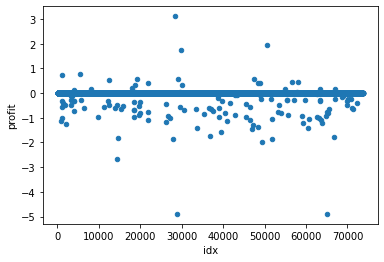

In [134]:
temp['train']['idx'] = temp['train'].index
temp['train'].plot.scatter('idx', 'profit')

<AxesSubplot:xlabel='idx', ylabel='profit'>

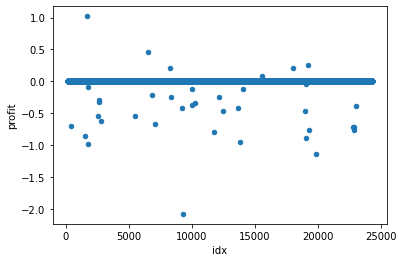

In [135]:
temp['test']['idx'] = temp['test'].index
temp['test'].plot.scatter('idx', 'profit')

In [136]:
temp['train']['pred'].abs().max(), temp['train'][temp['train']['profit'] > 0.4]['pred'].abs().min()

(0.99999994, 0.9999998)

<AxesSubplot:>

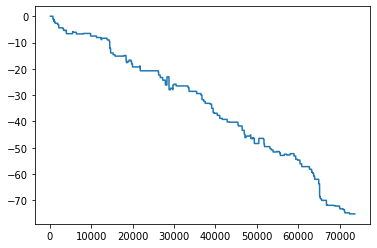

In [137]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

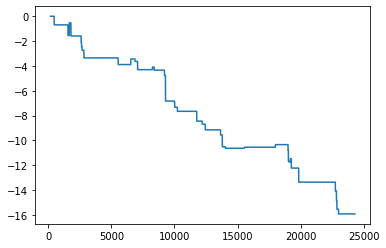

In [138]:
temp['test']['profit'].cumsum().plot()

In [139]:
sum(profits['train'])

-75.16109913530744

In [140]:
sum(profits['test'])

-15.923171839398892

In [141]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

-0.3566657325218225

In [142]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

-0.4002052463434704